In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AssetPricePredictor:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    def preprocess_data(self):
        # Normalize the close prices
        scaled_data = self.scaler.fit_transform(self.dataframe[['close']].values)
        return scaled_data
    
    def create_sequences(self, data, time_steps=1):
        sequences = []
        labels = []
        for i in range(len(data) - time_steps):
            sequences.append(data[i:i+time_steps])
            labels.append(data[i + time_steps])
        return np.array(sequences), np.array(labels)
    
    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        self.model.add(LSTM(50, return_sequences=False))
        self.model.add(Dense(25))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')
    
    def train_model(self, train_data, time_steps=1, epochs=10, batch_size=32):
        sequences, labels = self.create_sequences(train_data, time_steps)
        self.build_model((sequences.shape[1], sequences.shape[2]))
        self.model.fit(sequences, labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    def test_model(self, test_data, time_steps=1):
        sequences, labels = self.create_sequences(test_data, time_steps)
        predictions = self.model.predict(sequences)
        return predictions, labels
    
    def plot_predictions(self, test_data, test_predictions, time_steps=1):
        plt.figure(figsize=(14, 8))
        plt.plot(self.dataframe['time'], self.dataframe['close'], label='Actual Close Price')

        # Create a dummy array for inverse_transform
        dummy_test = np.zeros((len(test_predictions), 1))
        dummy_test[:, 0] = test_predictions.reshape(-1)
        inverted_test_predictions = self.scaler.inverse_transform(dummy_test)[:, 0]

        # Plotting test predictions
        test_range = range(len(self.dataframe) - len(test_predictions), len(self.dataframe))
        plt.plot(self.dataframe['time'].iloc[test_range], inverted_test_predictions, label='Predicted Close Price')

        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

    def predict_future_steps(self, steps=10, time_steps=1):
        scaled_data = self.preprocess_data()
        last_sequence = scaled_data[-time_steps:].reshape((1, time_steps, 1))
        predictions = []
        future_times = []

        time = self.dataframe['time'].iloc[-1]

        for _ in range(steps):
            next_prediction = self.model.predict(last_sequence)
            predictions.append(next_prediction[0, 0])
            future_times.append(time + pd.Timedelta(days=1))  # Adjust this timedelta based on your time intervals

            new_sequence = np.append(last_sequence[:, 1:, :], [[[next_prediction[0, 0]]]], axis=1)
            last_sequence = new_sequence
            time += pd.Timedelta(days=1)  # Adjust this timedelta based on your time intervals

        dummy_future = np.zeros((len(predictions), 1))
        dummy_future[:, 0] = predictions
        inverted_predictions = self.scaler.inverse_transform(dummy_future)[:, 0]

        future_df = pd.DataFrame({'time': future_times, 'close': inverted_predictions})
        
        return future_df
    
    def plot_future_predictions(self, predict_steps=10, future_steps=10):
        actual_data = self.dataframe[['time', 'close']].iloc[-predict_steps:]
        future_predictions_df = self.predict_future_steps(steps=future_steps, time_steps=predict_steps)
        
        plt.figure(figsize=(14, 8))
        plt.plot(actual_data['time'], actual_data['close'], label='Actual Close Price')
        plt.plot(future_predictions_df['time'], future_predictions_df['close'], label='Future Predicted Close Price', linestyle='--')

        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()
    
    def run(self, time_steps=1, epochs=10, batch_size=32, predict_steps=10):
        scaled_data = self.preprocess_data()
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]
        
        self.train_model(train_data, time_steps=time_steps, epochs=epochs, batch_size=batch_size)
        
        test_predictions, test_labels = self.test_model(test_data, time_steps=time_steps)
        
        self.plot_predictions(test_data, test_predictions, time_steps=time_steps)
        
        accuracy = np.mean(np.abs(test_predictions - test_labels) / test_labels)
        performance_stats = {
            'mean_squared_error': np.mean((test_predictions - test_labels)**2),
            'mean_absolute_error': np.mean(np.abs(test_predictions - test_labels)),
            'accuracy': accuracy
        }
        
        return performance_stats



Epoch 1/50


/Users/andrewdiedrich/Documents/quant/slingbot/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0766 - val_loss: 0.0286
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - val_loss: 4.6639e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 8.3033e-05
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 1.8261e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 3.0468e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 8.7655e-05
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 5.6545e-05
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 9.8880e-05
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 5.0784e-05
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 6.2453e-05
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 2.8198e-04
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

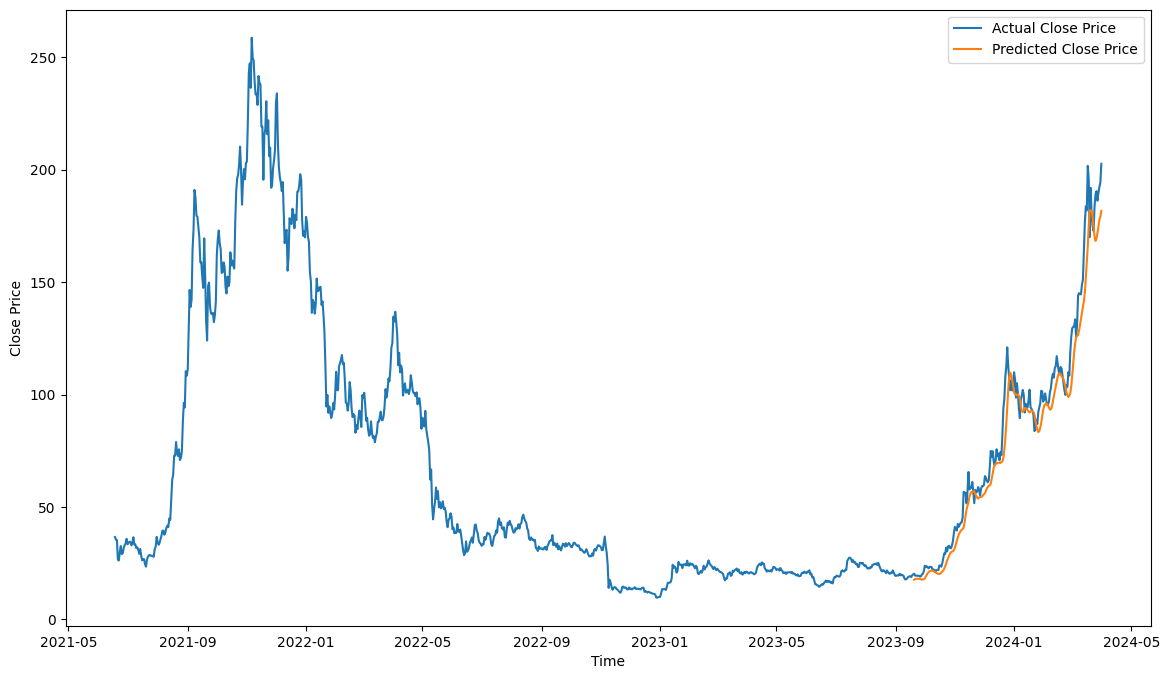

{'mean_squared_error': 0.0015608919082047564, 'mean_absolute_error': 0.028195774505776892, 'accuracy': 0.1108690551483331}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
         time       close
0  2024-04-01  184.549899
1  2024-04-02  183.950338
2  2024-04-03  181.413345
3  2024-04-04  178

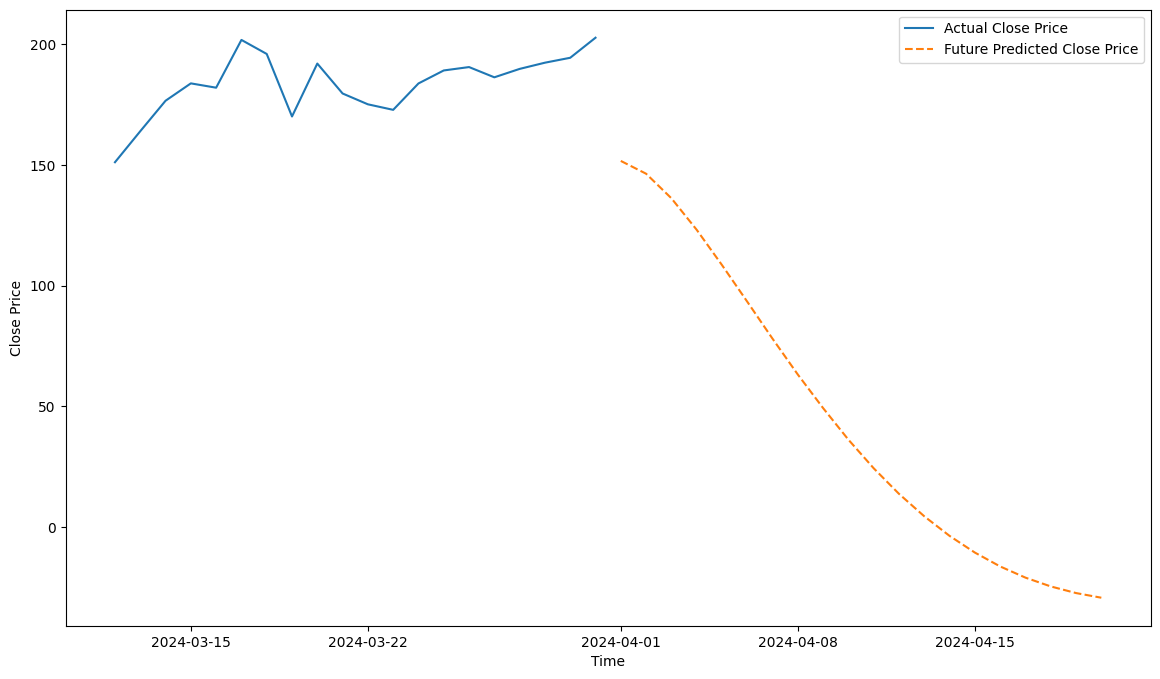

In [82]:
# get /Users/andrewdiedrich/Downloads/Kraken_OHLCVT/SOLUSD_1440.csv
data = pd.read_csv('../../../Kraken_OHLCVT/SOLUSD_1440.csv')

data.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'count']
data['time'] = pd.to_datetime(data['time'], unit='s')
data['close'] = data['close'].astype(float)
data['volume'] = data['volume'].astype(float)
data['count'] = data['count'].astype(float)
data['open'] = data['open'].astype(float)
data['high'] = data['high'].astype(float)
data['low'] = data['low'].astype(float)

df = data.dropna()

predictor = AssetPricePredictor(df)
performance_stats = predictor.run(time_steps=10, epochs=50, batch_size=64, predict_steps=20)
print(performance_stats)
future_predictions_df = predictor.predict_future_steps(steps=20, time_steps=10)
print(future_predictions_df)
predictor.plot_future_predictions(predict_steps=20, future_steps=20)